<a href="https://colab.research.google.com/github/Balaaabduljalil/naijaSentiment/blob/main/Copy_of_covid_data_attempt_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sentiment Analysis of Covid Vaccine Related Tweets in TwitterNG


---



---


In this notebook, tweets scraped from twitterNG between November 2020 and June 2022 are analysed with an aim to determine the wave of public opinion with regards to the covid-19 vaccines. Using social media data is an easier way of getting data compared to traditional ways like using data collection forms. Leveraging social media data could have its limitations but it makes data collection and opinion mining easy.



In [ ]:
# @title Persisting the output
from google.colab import drive
drive.mount('/content/drive')

import os

project_dir = '/content/drive/MyDrive/ArewaDSSentimentPaper'

if not os.path.isdir(project_dir):
  os.makedirs(project_dir)

%cd {project_dir}

Mounted at /content/drive
/content/drive/MyDrive/ArewaDSSentimentPaper


Next we install the required libraries not supported natively by colab

In [ ]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00


Libraries Import

In [ ]:
# importing needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer, AutoModelForSequenceClassification,XLMRobertaTokenizer,XLMRobertaForSequenceClassification
import torch


In [ ]:
# Load dataset
data = pd.read_csv('final.csv')
# renaming the label column for easier analysis
data.rename(columns={"final":"label"},inplace=True)
data.head()

,text,label
0,its covid it self not the vaccine sorry about ...,0
1,na covid ooooo rearing its head pls but d adve...,0
2,good morning aunty yeni in lagos people are be...,2
3,for where where the vaccine dey,0
4,waec on which date did buhari received his cov...,0


Next, the labels are inspected and the distribution is visualized. There seems to be an obvious imbalance with more than half of the tweets being neutral and the positive and negative labels sharing less than 50% .

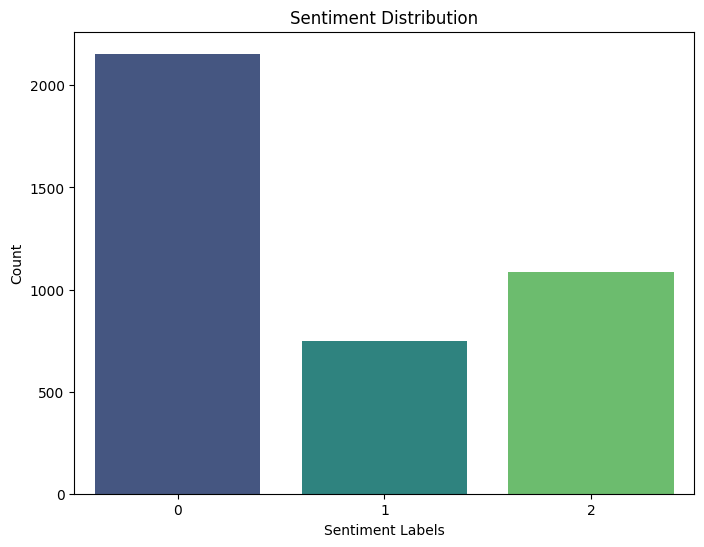

In [ ]:
# visualizing for analysis
# Count the number of occurrences for each sentiment label
sentiment_counts = data['label'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.xlabel("Sentiment Labels")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.show()


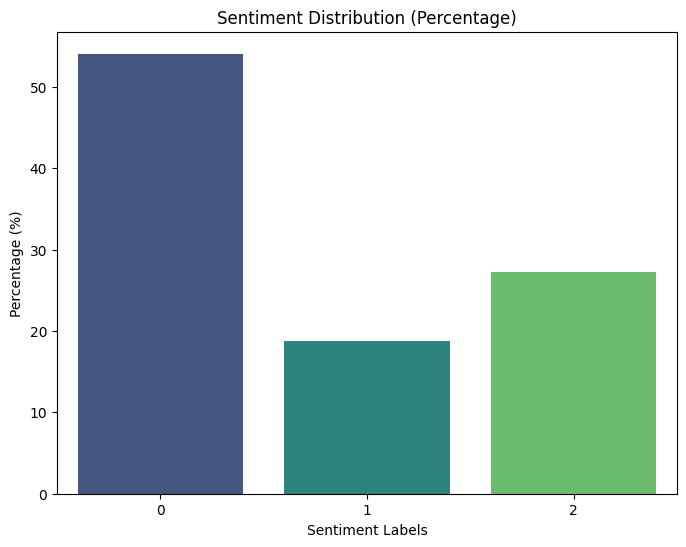

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences for each sentiment label
sentiment_counts = data['label'].value_counts()

# Calculate the percentage of each sentiment label
total_samples = len(data)
percentage_counts = (sentiment_counts / total_samples) * 100

# Plot the sentiment distribution with percentages
plt.figure(figsize=(8, 6))
sns.barplot(x=percentage_counts.index, y=percentage_counts.values, palette="viridis")
plt.xlabel("Sentiment Labels")
plt.ylabel("Percentage (%)")
plt.title("Sentiment Distribution (Percentage)")
plt.show()


Generating a word cloud to visualize the most important keywords in the tweets. It is obvious that this is related to vaccines!Even brands like pfizer and astrazeneca show up.

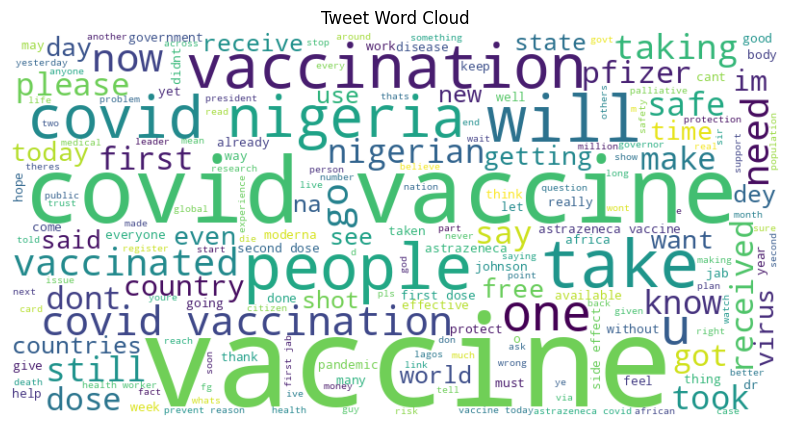

In [ ]:
tweets = data['text'].str.cat(sep=' ')  # Combine all tweets into one string

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tweets)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tweet Word Cloud")
plt.show()

Next is to split the dataset for training.

Tfidvectorizer is used to convert the text to numbers that can be used for training the models.

Naives Bayes, KNN and Decision Tree models are trained and the metrics on the validation data are compared

## Training the ML Models

## Classic Models

In [ ]:
# Split the data into training, validation, and test sets (80% train, 20% validation, 20% test)
train_data, test_data = train_test_split(data, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Preprocess the text data using TF-IDF (you can use other methods as well)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # can be adjusted
X_train = tfidf_vectorizer.fit_transform(train_data['text'])
X_val = tfidf_vectorizer.transform(val_data['text'])
X_test = tfidf_vectorizer.transform(test_data['text'])
y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

# Train Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_val)

# Calculate metrics for Naive Bayes
nb_accuracy = accuracy_score(y_val, nb_predictions)
nb_precision = precision_score(y_val, nb_predictions, average='weighted')
nb_recall = recall_score(y_val, nb_predictions, average='weighted')
nb_f1 = f1_score(y_val, nb_predictions, average='weighted')

print(f'Naive Bayes Validation Accuracy: {nb_accuracy:.2f}')
print(f'Naive Bayes Precision: {nb_precision:.2f}')
print(f'Naive Bayes Recall: {nb_recall:.2f}')
print(f'Naive Bayes F1 Score: {nb_f1:.2f}')

# Train K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_val)

# Calculate metrics for K-Nearest Neighbors
knn_accuracy = accuracy_score(y_val, knn_predictions)
knn_precision = precision_score(y_val, knn_predictions, average='weighted')
knn_recall = recall_score(y_val, knn_predictions, average='weighted')
knn_f1 = f1_score(y_val, knn_predictions, average='weighted')

print(f'K-Nearest Neighbors Validation Accuracy: {knn_accuracy:.2f}')
print(f'K-Nearest Neighbors Precision: {knn_precision:.2f}')
print(f'K-Nearest Neighbors Recall: {knn_recall:.2f}')
print(f'K-Nearest Neighbors F1 Score: {knn_f1:.2f}')

# Train Decision Trees
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_val)

# Calculate metrics for Decision Trees
dt_accuracy = accuracy_score(y_val, dt_predictions)
dt_precision = precision_score(y_val, dt_predictions, average='weighted')
dt_recall = recall_score(y_val, dt_predictions, average='weighted')
dt_f1 = f1_score(y_val, dt_predictions, average='weighted')

print(f'Decision Trees Validation Accuracy: {dt_accuracy:.2f}')
print(f'Decision Trees Precision: {dt_precision:.2f}')
print(f'Decision Trees Recall: {dt_recall:.2f}')
print(f'Decision Trees F1 Score: {dt_f1:.2f}')



Naive Bayes Validation Accuracy: 0.57
Naive Bayes Precision: 0.65
Naive Bayes Recall: 0.57
Naive Bayes F1 Score: 0.45
K-Nearest Neighbors Validation Accuracy: 0.62
K-Nearest Neighbors Precision: 0.61
K-Nearest Neighbors Recall: 0.62
K-Nearest Neighbors F1 Score: 0.61
Decision Trees Validation Accuracy: 0.53
Decision Trees Precision: 0.53
Decision Trees Recall: 0.53
Decision Trees F1 Score: 0.53


The best of the three models depends on the metric chosen. But looking at F1 score, KNN did a tad better.

Up next, training a language model. More specifically, finetuning a pretrained language model. In this case, bert-base-uncased.


## Bert

In [ ]:
# Train BERT (uncased)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Prepare the data for BERT
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_data['text'].tolist(), train_data['label'].tolist(), tokenizer)
val_dataset = SentimentDataset(val_data['text'].tolist(), val_data['label'].tolist(), tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert-sentiment',
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1000,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    remove_unused_columns=False
)


# Train BERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

# Evaluate BERT on the validation set
results = trainer.evaluate()





Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
500,0.097000,1.120151


In [ ]:
# Evaluate BERT on the validation set
bert_predictions = trainer.predict(val_dataset).predictions.argmax(axis=1)  # Get predicted labels

# Calculate accuracy manually
y_true = y_val  # Actual labels from the validation data
bert_accuracy = accuracy_score(y_true, bert_predictions)

# Calculate other metrics (precision, recall, F1-score)
bert_precision = precision_score(y_true, bert_predictions, average='weighted')
bert_recall = recall_score(y_true, bert_predictions, average='weighted')
bert_f1 = f1_score(y_true, bert_predictions, average='weighted')

print(f'BERT Validation Accuracy: {bert_accuracy:.2f}')
print(f'BERT Precision: {bert_precision:.2f}')
print(f'BERT Recall: {bert_recall:.2f}')
print(f'BERT F1 Score: {bert_f1:.2f}')

BERT Validation Accuracy: 0.70
BERT Precision: 0.70
BERT Recall: 0.70
BERT F1 Score: 0.70


Somehow, all the scores are the same. Is something wrong perhaps?

In [ ]:
# Iterate through some examples and compare predictions to true labels
num_examples_to_inspect = 10  #

for i in range(num_examples_to_inspect):
    predicted_label = bert_predictions[i]
    true_label = val_data['label'].iloc[i]
    text = val_data['text'].iloc[i]  # Get the corresponding text

    # Decode the labels if needed (e.g., from numeric to class names)
    # For example, if 0 represents 'Negative', 1 represents 'Neutral', and 2 represents 'Positive':
    label_mapping = {0: 'Neutral', 1: 'Negative', 2: 'Positive'}
    predicted_label = label_mapping[predicted_label]
    true_label = label_mapping[true_label]

    # Print the prediction and the true label
    print(f"Text: {text}")
    print(f"Predicted Label: {predicted_label}")
    print(f"True Label: {true_label}")
    print("\n")

Text: after reading that i wont be taking the vaccine im sorry i feel so bad for her mom
Predicted Label: Neutral
True Label: Neutral


Text: next it will be that is hoarding the vaccine our prince hasnt done any thing wrong in fact he can do no wrong
Predicted Label: Negative
True Label: Negative


Text: hi have you taken the vaccine
Predicted Label: Neutral
True Label: Neutral


Text: i have registered and schedule for covid vaccine you can also register to get your vaccine faster through the below portal the portal is
Predicted Label: Positive
True Label: Positive


Text: come covid vaccine don dey lagos
Predicted Label: Neutral
True Label: Neutral


Text: guys pls get vaccinated took my nd dose at iru local govt in victoria island there was no queue covid is real the vaccine is our only real protection
Predicted Label: Positive
True Label: Positive


Text: so whats with pushing the vaccine as though it would keep you completely safe you stand a chance of getting sick as well as the

All the examples look good though.

In [ ]:
# Evaluating on the test dataset
# Load the test dataset and prepare it for BERT
test_dataset = SentimentDataset(test_data['text'].tolist(), test_data['label'].tolist(), tokenizer)

bert_test_predictions = trainer.predict(test_dataset).predictions.argmax(axis=1)  # Get predicted labels
y_true = y_test  # Actual labels from the test data
bert_test_accuracy = accuracy_score(y_true, bert_test_predictions)

# Calculate metrics for BERT on the test set
bert_test_precision = precision_score(test_data['label'], bert_test_predictions, average='weighted')
bert_test_recall = recall_score(test_data['label'], bert_test_predictions, average='weighted')
bert_test_f1 = f1_score(test_data['label'], bert_test_predictions, average='weighted')

print(f'BERT Test Accuracy: {bert_test_accuracy:.2f}')
print(f'BERT Test Precision: {bert_test_precision:.2f}')
print(f'BERT Test Recall: {bert_test_recall:.2f}')
print(f'BERT Test F1 Score: {bert_test_f1:.2f}')


BERT Test Accuracy: 0.68
BERT Test Precision: 0.69
BERT Test Recall: 0.68
BERT Test F1 Score: 0.68


Eval scores look the same too.

## Afro-xlmr

In [ ]:
# Train afro-xlmr
tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-base")
model = AutoModelForSequenceClassification.from_pretrained("Davlan/afro-xlmr-base", num_labels=3)

# Prepare the data for afro-xlmr
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_data['text'].tolist(), train_data['label'].tolist(), tokenizer)
val_dataset = SentimentDataset(val_data['text'].tolist(), val_data['label'].tolist(), tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./afro-xlmr-sentiment',
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1000,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_dir='./afro_logs',
    logging_steps=100,
    load_best_model_at_end=True,
    remove_unused_columns=False
)


# Train afro-xlmr
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

# Evaluate afro-xlmr on the validation set
results = trainer.evaluate()





Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
500,0.231200,0.929499


In [ ]:
for i in(results.items()):
  print(i)

('eval_loss', 1.059503436088562)
('eval_runtime', 0.9421)
('eval_samples_per_second', 846.001)
('eval_steps_per_second', 26.537)
('epoch', 10.0)


In [ ]:
# Evaluate afro-xlmr on the validation set
afro_xlmr_predictions = trainer.predict(val_dataset).predictions.argmax(axis=1)  # Get predicted labels

# Calculate accuracy manually
y_true = y_val  # Actual labels from the validation data
afro_xlmr_accuracy = accuracy_score(y_true, afro_xlmr_predictions)

# Calculate other metrics (precision, recall, F1-score)
afro_xlmr_precision = precision_score(y_true, bert_predictions, average='weighted')
afro_xlmr_recall = recall_score(y_true, bert_predictions, average='weighted')
afro_xlmr_f1 = f1_score(y_true, bert_predictions, average='weighted')

print(f'afro_xlmr Validation Accuracy: {afro_xlmr_accuracy:.2f}')
print(f'afro_xlmr Precision: {afro_xlmr_precision:.2f}')
print(f'afro_xlmr Recall: {afro_xlmr_recall:.2f}')
print(f'afro_xlmr F1 Score: {afro_xlmr_f1:.2f}')

afro_xlmr Validation Accuracy: 0.71
afro_xlmr Precision: 0.70
afro_xlmr Recall: 0.70
afro_xlmr F1 Score: 0.70


## Xlm-Roberta

In [ ]:
# Train xlm-roberta
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForSequenceClassification.from_pretrained(
    'xlm-roberta-base',num_labels=3)

# Prepare the data for afriberta
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_data['text'].tolist(), train_data['label'].tolist(), tokenizer)
val_dataset = SentimentDataset(val_data['text'].tolist(), val_data['label'].tolist(), tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./roberta-sentiment',
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1000,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_dir='./robertalogs',
    logging_steps=100,
    load_best_model_at_end=True,
    remove_unused_columns=False
)


# Train afriberta
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

# Evaluate afriberta on the validation set
results = trainer.evaluate()





Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
500,0.407300,0.765263


In [ ]:
# Evaluate afro-xlmr on the validation set
xlm_roberta_predictions = trainer.predict(val_dataset).predictions.argmax(axis=1)  # Get predicted labels

# Calculate accuracy manually
y_true = y_val  # Actual labels from the validation data
xlm_roberta_accuracy = accuracy_score(y_true, xlm_roberta_predictions)

# Calculate other metrics (precision, recall, F1-score)
xlm_roberta_precision = precision_score(y_true, xlm_roberta_predictions, average='weighted')
xlm_roberta_recall = recall_score(y_true, xlm_roberta_predictions, average='weighted')
xlm_roberta_f1 = f1_score(y_true, xlm_roberta_predictions, average='weighted')

print(f'xlm_roberta Validation Accuracy: {xlm_roberta_accuracy:.2f}')
print(f'xlm_roberta Precision: {xlm_roberta_precision:.2f}')
print(f'xlm_roberta Recall: {xlm_roberta_recall:.2f}')
print(f'xlm_roberta F1 Score: {xlm_roberta_f1:.2f}')

xlm_roberta Validation Accuracy: 0.71
xlm_roberta Precision: 0.71
xlm_roberta Recall: 0.71
xlm_roberta F1 Score: 0.71


In [ ]:
# @title Final Evaluation on test data
# Final Evaluation of best model on the test dataset

# Evaluating on the test dataset
# Load the test dataset and prepare it for xlm_roberta
test_dataset = SentimentDataset(test_data['text'].tolist(), test_data['label'].tolist(), tokenizer)

xlm_roberta_test_predictions = trainer.predict(test_dataset).predictions.argmax(axis=1)  # Get predicted labels

# Calculate accuracy manually
y_true = y_val  # Actual labels from the validation data
xlm_roberta_accuracy = accuracy_score(y_true, xlm_roberta_predictions)

# Calculate other metrics (precision, recall, F1-score)
xlm_roberta_precision = precision_score(y_true, xlm_roberta_predictions, average='weighted')
xlm_roberta_recall = recall_score(y_true, xlm_roberta_predictions, average='weighted')
xlm_roberta_f1 = f1_score(y_true, xlm_roberta_predictions, average='weighted')

print(f'xlm_roberta Test Accuracy: {xlm_roberta_accuracy:.2f}')
print(f'xlm_roberta Test Precision: {xlm_roberta_precision:.2f}')
print(f'xlm_roberta TestRecall: {xlm_roberta_recall:.2f}')
print(f'xlm_roberta Test F1 Score: {xlm_roberta_f1:.2f}')


xlm_roberta Test Accuracy: 0.71
xlm_roberta Test Precision: 0.71
xlm_roberta TestRecall: 0.71
xlm_roberta Test F1 Score: 0.71


# Topic Modelling



Here, I want to see the direction of the discussions. Latent Dirichlet Allocation (LDA) is used for the topic modelling.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Specify vaccine-related keywords
vaccine_keywords = ["vaccine", "covid", "immunity", "distribution", "side effects","pfizer","moderna","johnson"]
data = pd.read_csv('final.csv')
text_data = data['text'].tolist()
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# LDA Model
num_topics = 10  # Number
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, random_state=42)
lda_topic_matrix = lda_model.fit_transform(tfidf_matrix)

# Print the topics and associated words
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_keywords_idx = topic.argsort()[-5:][::-1]  # Get the top 5 keywords for each topic
    top_keywords = [feature_names[i] for i in top_keywords_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_keywords)}")

# Assign topics to documents
topic_assignments = lda_topic_matrix.argmax(axis=1)


The discussions all seem to be around vaccine, vaccination, how the vaccines are free and even about the president (Buhari) at the time.
Astrazeneca is the only brand to feature in the top 10 topics.
This can be attributed to the fact that it was the first vaccine brand to be introduced in the country.


In [ ]:
# Print the topics and associated words
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model.components_):
    top_keywords_idx = topic.argsort()[-10:][::-1]  # Get the top 10 keywords for each topic
    top_keywords = [feature_names[i] for i in top_keywords_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_keywords)}")

    # Create a word cloud for each topic
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_keywords))

    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx + 1} - Top Keywords")
    plt.axis("off")
    plt.show()

# Assign topics to documents
topic_assignments = lda_topic_matrix.argmax(axis=1)


Here too, word cloud for the top discussed topics.

# Vaccine Brands

In [ ]:
# Getting sentiments associated with each vaccine brands
import re
import pandas as pd

# Sample data
data = pd.read_csv('final.csv')
tweets = data['text'].tolist()

# Define the vaccine names
vaccine_names = ["AstraZeneca", "Pfizer", "Moderna", "Johnson"]

# Initialize counters, sentiment mapping, and sentiment counts
mention_counts = {name: 0 for name in vaccine_names}
mention_sentiments = {name: [] for name in vaccine_names}

# Define sentiment mapping (modify as needed)
sentiment_mapping = {
    0: "Neutral",
    1: "Negative",
    2: "Positive"
}

# Initialize sentiment counts
sentiment_counts = {name: {"Positive": 0, "Negative": 0, "Neutral": 0} for name in vaccine_names}

# Iterate through tweets
for tweet, sentiment in zip(tweets, data['final']):
    for name in vaccine_names:
        # Use regex to find mentions (case-insensitive)
        mentions = re.findall(fr'\b{name}\b', tweet, re.IGNORECASE)

        # If mentions are found, update counts and sentiments
        if mentions:
            mention_counts[name] += len(mentions)
            mention_sentiments[name].extend([sentiment_mapping[sentiment]] * len(mentions))
            # Update sentiment counts
            sentiment_counts[name][sentiment_mapping[sentiment]] += len(mentions)

# Calculate percentage positive, negative, and neutral sentiment for each brand
percentage_sentiments = {}
for name in vaccine_names:
    total_mentions = mention_counts[name]
    positive_mentions = sentiment_counts[name]["Positive"]
    negative_mentions = sentiment_counts[name]["Negative"]
    neutral_mentions = sentiment_counts[name]["Neutral"]

    if total_mentions > 0:
        percentage_positive = (positive_mentions / total_mentions) * 100
        percentage_negative = (negative_mentions / total_mentions) * 100
        percentage_neutral = (neutral_mentions / total_mentions) * 100
    else:
        percentage_positive = 0
        percentage_negative = 0
        percentage_neutral = 0

    percentage_sentiments[name] = {
        "Positive": percentage_positive,
        "Negative": percentage_negative,
        "Neutral": percentage_neutral
    }

# Print the results
for name in vaccine_names:
    print(f"{name} Mentions: {mention_counts[name]}")
    print(f"{name} Percentage Positive: {percentage_sentiments[name]['Positive']:.2f}%")
    print(f"{name} Percentage Negative: {percentage_sentiments[name]['Negative']:.2f}%")
    print(f"{name} Percentage Neutral: {percentage_sentiments[name]['Neutral']:.2f}%")


Looking closely at the vaccine brands, the discussion is majorly non-negative.

Though, some strange conspiracy theories were spread at the time.

In [ ]:
# Create a DataFrame from percentage_sentiments
df = pd.DataFrame.from_dict(percentage_sentiments, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'Vaccine'}, inplace=True)
# Plot the percentages as a bar chart
plt.figure(figsize=(10, 6))
ax = df.plot(x='Vaccine', kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Vaccine Brand')
plt.ylabel('Percentage (%)')
plt.title('Sentiments Associated with Vaccine Brands')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=0)
plt.show()


Johnson has the highest positive tweets and this can be attributed to the fact that the Johnson and Johnson brand was a single shot vaccine. It was administered just once compared to the other brands that were two doses not to mention the booster shots.  

# Is it even significant?

In [ ]:
# Checking significant difference between negative and non-negative tweets

# Separate the dataset into negative and non-negative tweets
negative_tweets = data[data['final'] == 1]  #  1 represents negative sentiment
non_negative_tweets = data[data['final'].isin([0, 2])]  # 0 and 2 represent neutral and positive sentiment

# Apply LDA to negative tweets
lda_negative = LatentDirichletAllocation(n_components=num_topics, max_iter=10, random_state=0)
lda_topic_matrix_negative = lda_negative.fit_transform(tfidf_vectorizer.transform(negative_tweets['text']))

# Apply LDA to non-negative tweets
lda_non_negative = LatentDirichletAllocation(n_components=num_topics, max_iter=10, random_state=0)
lda_topic_matrix_non_negative = lda_non_negative.fit_transform(tfidf_vectorizer.transform(non_negative_tweets['text']))

# Perform statistical tests (e.g., chi-squared test) to compare topic distributions
from scipy.stats import chi2_contingency

topic_distributions_negative = lda_topic_matrix_negative.argmax(axis=1)
topic_distributions_non_negative = lda_topic_matrix_non_negative.argmax(axis=1)

# Ensure the two arrays have the same length
min_length = min(len(topic_distributions_negative), len(topic_distributions_non_negative))
topic_distributions_negative = topic_distributions_negative[:min_length]
topic_distributions_non_negative = topic_distributions_non_negative[:min_length]

# Create a contingency table
contingency_table = pd.crosstab(topic_distributions_negative, topic_distributions_non_negative)

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Determine if the difference is significant
if p < 0.05:
    print("There is a significant difference between topics in negative and non-negative tweets.")
else:
    print("There is no significant difference between topics in negative and non-negative tweets.")


There is a significant difference between topis in the negative and non-negative tweets.

In [ ]:
# Rank and list the top topics in negative tweets
top_topics_negative = lda_negative.components_.argsort()[:, ::-1][:, :5]  # Get the top 5 keywords for each topic
for i, topic in enumerate(top_topics_negative):
    top_keywords = [feature_names[i] for i in topic]
    print(f"Top Topic {i + 1} in Negative Tweets: {', '.join(top_keywords)}")

# Rank and list the top topics in non-negative tweets
top_topics_non_negative = lda_non_negative.components_.argsort()[:, ::-1][:, :5]  # Get the top 5 keywords for each topic
for i, topic in enumerate(top_topics_non_negative):
    top_keywords = [feature_names[i] for i in topic]
    print(f"Top Topic {i + 1} in Non-Negative Tweets: {', '.join(top_keywords)}")


This may need more work.